# Let's try approach semantic analysis with fuzzy logic + ml

The goal of this study is to apply fuzzy logic and custom word vector embeddings to enhance emotion detection in textual analysis. 

We apply support vector machine technology to different vector embeddings to create custom vector embedding of words that would represent different types of moods. 

We then generate fuzzy logic rules to detect emotional state based on these moods. The proposed approach is to use evolutionary algorithms to receive best sets of logic rules that would apply for particular task. 

By instituting trapezoidal membership functions across a spectrum of emotional states and employing a robust set of fuzzy inference rules, the proposed approach yields a granular and context-sensitive interpretation of textual moods.

![nlp-ml](../images/nlp_fuzzy.png)

In [8]:
# imports section
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from gensim import corpora, models, similarities
import string

import gensim.downloader as api
from gensim.models import Word2Vec
import itertools

In [2]:
expected = {}
expected['lonely'] = [0.1, 0.5, 1, 0.6, 0.1, 0.0]

In [1]:
# Define the lexicon with mood vectors
moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}
moods_indeces = {y.lower(): x for x, y in moods.items()}

lexicon = {
    # "frustrated": [0.8, 0.4, 0.3, 0, 0, 0], 
    "anxious": [0.3, 0.9, 0.4, 0, 0, 0.1], # "disappointed": [0.5, 0.3, 0.8, 0.1, 0, 0], 
    "furious": [0.9, 0.3, 0.2, 0, 0, 0], "peaceful": [0, 0, 0, 1, 0.4, 0.2], 
    "hate": [0.9, 0.3, 0.3, 0, 0, 0], "joyful": [0, 0, 0, 0.2, 0.9, 0.7], 
    "unacceptable": [0.9, 0.6, 0.6, 0, 0, 0], "thrilled": [0, 0, 0, 0, 0.6, 1], 
    "infuriating": [0.9, 0.8, 0.6, 0, 0, 0], "irate": [0.9, 0.2, 0.1, 0, 0, 0], 
    "terrible": [0.9, 0.7, 0.7, 0, 0, 0], "nervous": [0.2, 0.8, 0.3, 0.1, 0, 0.2],
    "melancholy": [0.1, 0.4, 0.9, 0.2, 0, 0], "depressed": [0.1, 0.1, 0.9, 0.2, 0, 0], 
    "gloomy": [0.1, 0.1, 0.8, 0.3, 0, 0], "serene": [0, 0, 0, 0.9, 0.8, 0.9], 
    "elated": [0, 0, 0, 0.1, 0.8, 0.9], "ecstatic": [0, 0, 0, 0, 0.7, 1],
    "overjoyed": [0.1, 0.1, 0.1, 0.1, 1, 0.9], "gleeful": [0.1, 0.1, 0.1, 0.1, 0.9, 0.8],
    "cheerful": [0.1, 0.1, 0.1, 0.1, 0.8, 0.5], "optimistic": [0.1, 0.2, 0.1, 0.7, 0.8, 0.6],
    "buoyant": [0.1, 0.2, 0.1, 0.8, 0.7, 0.7], "enthusiastic": [0.2, 0.3, 0.1, 0.6, 0.8, 0.9],
    "upbeat": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7], "festive": [0.1, 0.1, 0.1, 0.7, 0.8, 0.7],
    "playful": [0.1, 0.2, 0.1, 0.6, 0.7, 0.8], "vivacious": [0.1, 0.2, 0.1, 0.6, 0.8, 0.7],
    "jovial": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7], "amused": [0.1, 0.2, 0.1, 0.6, 0.7, 0.7],
    "blissful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7], "grateful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7],
    "tranquil": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6], "relaxed": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6],
    "comfortable": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], "cozy": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6],
    "warm": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], "inviting": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "satisfied": [0.1, 0.1, 0.2, 0.6, 0.5, 0.3], "pleasant": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "pleased" : [0.1, 0.1, 0.1, 0.9, 0.8, 0.3], "mellow": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6] , 
    "happy": [0.1, 0.1, 0.1, 0.7, 1, 0.6]
    }

In [4]:
corpus = api.load('glove-wiki-gigaword-100')

vector = corpus['computer']
print(vector)

[-1.6298e-01  3.0141e-01  5.7978e-01  6.6548e-02  4.5835e-01 -1.5329e-01
  4.3258e-01 -8.9215e-01  5.7747e-01  3.6375e-01  5.6524e-01 -5.6281e-01
  3.5659e-01 -3.6096e-01 -9.9662e-02  5.2753e-01  3.8839e-01  9.6185e-01
  1.8841e-01  3.0741e-01 -8.7842e-01 -3.2442e-01  1.1202e+00  7.5126e-02
  4.2661e-01 -6.0651e-01 -1.3893e-01  4.7862e-02 -4.5158e-01  9.3723e-02
  1.7463e-01  1.0962e+00 -1.0044e+00  6.3889e-02  3.8002e-01  2.1109e-01
 -6.6247e-01 -4.0736e-01  8.9442e-01 -6.0974e-01 -1.8577e-01 -1.9913e-01
 -6.9226e-01 -3.1806e-01 -7.8565e-01  2.3831e-01  1.2992e-01  8.7721e-02
  4.3205e-01 -2.2662e-01  3.1549e-01 -3.1748e-01 -2.4632e-03  1.6615e-01
  4.2358e-01 -1.8087e+00 -3.6699e-01  2.3949e-01  2.5458e+00  3.6111e-01
  3.9486e-02  4.8607e-01 -3.6974e-01  5.7282e-02 -4.9317e-01  2.2765e-01
  7.9966e-01  2.1428e-01  6.9811e-01  1.1262e+00 -1.3526e-01  7.1972e-01
 -9.9605e-04 -2.6842e-01 -8.3038e-01  2.1780e-01  3.4355e-01  3.7731e-01
 -4.0251e-01  3.3124e-01  1.2576e+00 -2.7196e-01 -8

In [5]:
print(corpus['computer'][0])

-0.16298


In [6]:
data = ''

with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')
print(adjectives[:20])

['abandoned', 'able', 'absolute', 'adorable', 'adventurous', 'academic', 'acceptable', 'acclaimed', 'accomplished', 'accurate', 'aching', 'acidic', 'acrobatic', 'active', 'actual', 'adept', 'admirable', 'admired', 'adolescent', 'adorable']


In [9]:
adjectives_vectors = {}

for adjective in adjectives:
    adjectives_vectors[adjective] = corpus[adjective]

# print(adjectives_vectors)
for key, value in itertools.islice(adjectives_vectors.items(), 2):
    print(key, ":", value)

abandoned : [ 0.43756    0.22949   -0.24099    0.42471   -0.25692    0.073755
 -0.096612   0.46294    0.85405    0.30859    0.35545    0.81983
  0.20312   -0.1225     0.17376   -0.62581    0.48522    0.23915
 -0.24558   -0.11948    0.69671    0.57527    0.65548   -0.029388
 -0.19702   -0.4308    -0.77335   -0.5166    -0.201      0.48815
  0.23728    0.31009   -0.25274   -0.042121  -0.19871   -0.17874
  0.019558  -0.42301    0.0743    -0.073421  -0.57583   -0.30048
  0.64496   -0.071048   0.52107    0.17243   -0.13616    0.97539
  0.23503   -0.28925   -0.072434   0.10553    0.24934    0.82306
  0.21013   -1.7977    -0.54545   -0.29966    1.0294     0.16126
  0.081623   0.53188    0.20484    0.36831    0.7118    -0.23808
  0.16678   -0.16994   -0.56703   -0.22874   -0.042396  -0.0065193
  0.01364   -0.2084    -0.35861   -0.055815   0.16845    0.46759
 -0.9905     0.35124   -0.070496   0.20322   -0.20443    0.75299
 -0.70367    0.19664    0.045248  -0.044681  -0.95952    0.31755
 -0.11741

Using ML we can extend defined vectors to the whole space of words of interest.
ML - classification and regression;
Here we are going to apply some regression:
- Polynomial regression
- Support vector regression 
- Decision tree regression
- Random forest regression 
- 

Also we ca apply:
- Dimensionality reduction 
- Kohonen map
- 


In [9]:
print(lexicon["frustrated"])

KeyError: 'frustrated'

Let's try applying polynomial regression to mapping adjactives to our vector space

In [10]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


# Define the degree of the polynomial features
degree = 3  # You can experiment with different degrees

# Create a pipeline that includes PolynomialFeatures and LinearRegression
model = Pipeline([
    ('poly', PolynomialFeatures(degree=degree)),
    ('linear', LinearRegression())
])

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append(lexicon[key])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

abandoned : [[0.32317639 0.25339492 0.24257624 0.47616552 0.52784361 0.42721445]]
able : [[0.2992916  0.34903521 0.24096157 0.60392428 0.57864176 0.34701217]]
absolute : [[0.35318007 0.27168152 0.27121194 0.47428524 0.49266734 0.41936673]]
adorable : [[0.22084917 0.24326469 0.18947029 0.44065253 0.66891085 0.58757899]]
adventurous : [[0.22041089 0.25171863 0.17750381 0.51526528 0.62645102 0.62195696]]
academic : [[0.29220441 0.24158266 0.225727   0.52612072 0.56543346 0.47077341]]
acceptable : [[0.38258279 0.2767824  0.28608295 0.44254501 0.44166223 0.3503901 ]]
acclaimed : [[0.2972886  0.25117975 0.22408781 0.52039084 0.59370068 0.5127901 ]]
accomplished : [[0.27403816 0.22458991 0.19826061 0.52999849 0.60410334 0.52231761]]
accurate : [[0.29455266 0.24777829 0.22181902 0.50997164 0.56196879 0.47435633]]


Support vector regression:

In [12]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append(lexicon[key])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

abandoned : [[0.36450785 0.27966769 0.31859443 0.50023933 0.4371489  0.34419666]]
able : [[0.3430226  0.32288296 0.28917978 0.54112484 0.47876259 0.35876806]]
absolute : [[0.37397818 0.29097715 0.32589258 0.5177005  0.44704643 0.35855004]]
adorable : [[0.28049398 0.26668014 0.27283056 0.41543006 0.58737366 0.48421475]]
adventurous : [[0.28793654 0.28654378 0.25081813 0.48273499 0.57142011 0.52699778]]
academic : [[0.35202655 0.27490655 0.31864453 0.53357321 0.45016868 0.37739466]]
acceptable : [[0.42209738 0.31427118 0.32262799 0.50984958 0.43412611 0.32382094]]
acclaimed : [[0.34911582 0.26365228 0.30469808 0.53400377 0.48816278 0.40375973]]
accomplished : [[0.30862104 0.2553403  0.25841672 0.55217642 0.56411535 0.47189207]]
accurate : [[0.35404155 0.27981558 0.30862057 0.53763056 0.46982867 0.38353912]]


In [ ]:
# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

print(lexicon_trained['obnoxious'])
print(lexicon_trained['lonely'])
print(lexicon_trained['hilarious'])

SVR for one parameter:

In [13]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    x_train.append(adjectives_vectors[key])
    y_train.append([lexicon[key][0], 0])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

# Train the model
model.fit(x_train, y_train)

lexicon_trained = {}
for key in adjectives_vectors:
    result = model.predict([adjectives_vectors[key]])
    lexicon_trained[key] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

abandoned : 0.36450785095391314
able : 0.3430226031808837
absolute : 0.3739781823882929
adorable : 0.2804939785809792
adventurous : 0.28793654132037694
academic : 0.3520265512544812
acceptable : 0.4220973767652725
acclaimed : 0.3491158160135293
accomplished : 0.30862103813915764
accurate : 0.3540415527531092


In [ ]:
# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

print(lexicon_trained['obnoxious'])
print(lexicon_trained['lonely'])
print(lexicon_trained['hilarious'])

SVR for each parameter separately:

In [14]:
lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

for i in range(6):
    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
    model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

    x_train, y_train = [], []
    for key in lexicon.keys():
        x_train.append(adjectives_vectors[key])
        y_train.append([lexicon[key][i], 0])

    x_train_np = np.array(x_train)
    y_train_np = np.array(y_train)

    # Train the model
    model.fit(x_train, y_train)

    for key in adjectives_vectors:
        result = model.predict([adjectives_vectors[key]])
        lexicon_trained[key][i] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)


abandoned : [0.36450785095391314, 0.27966768533887787, 0.3185944340447965, 0.50023933154893, 0.43714889590514383, 0.344196655118454]
able : [0.3430226031808837, 0.3228829556090227, 0.2891797764790672, 0.5411248425277152, 0.47876259123198295, 0.358768061928111]
absolute : [0.3739781823882929, 0.290977150491994, 0.32589258498838686, 0.517700500259393, 0.44704642886920065, 0.35855004237786536]
adorable : [0.2804939785809792, 0.26668014253660194, 0.2728305555258477, 0.4154300568807142, 0.587373663684237, 0.4842147506961325]
adventurous : [0.28793654132037694, 0.2865437779274545, 0.25081812588681457, 0.4827349869612562, 0.5714201072555158, 0.526997777242216]
academic : [0.3520265512544812, 0.2749065530747645, 0.31864453221768485, 0.53357321156012, 0.45016867875657973, 0.3773946586718183]
acceptable : [0.4220973767652725, 0.31427118470015436, 0.32262798564378603, 0.5098495810101824, 0.43412611489875147, 0.3238209382193609]
acclaimed : [0.3491158160135293, 0.2636522751214867, 0.30469808131618

In [11]:
# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

print(lexicon_trained['obnoxious'])
print(lexicon_trained['lonely'])
print(lexicon_trained['hilarious'])

[0.43871399620322826, 0.3110284720210269, 0.2971744716197592, 0.3551259287830437, 0.4311651196038902, 0.38796361043208955]
[0.32015740730301884, 0.2886747887332214, 0.4003978575048952, 0.4113944941311295, 0.43092495284093657, 0.3093998501118935]
[0.3898920053982028, 0.32554884539953455, 0.35671485930020275, 0.41503415189479337, 0.4502043289405145, 0.4170921875029631]


TODO:
- try dimensionality reduction / kohonen maps
- fuzzy logic automated rule generation
- fl application
- validation
- text processing


In [ ]:
validation_data = {'lonely' : [0, 0, 0.8, 0.5, 0, 0]}

In [ ]:
# print(lexicon)

print(adjectives_vectors)

## Lets try principal component analysis

Explained variance ratio: [0.13988787 0.12037184]


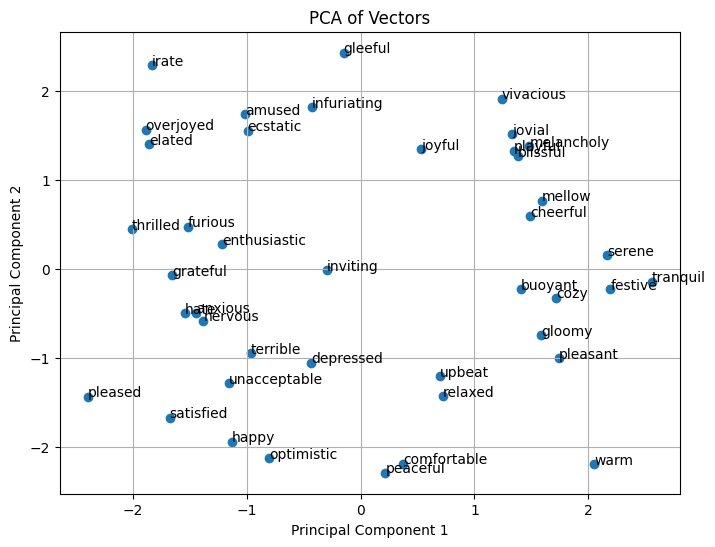

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

lexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

# print(lexicon_embedded)

# Convert dictionary values to a NumPy array
X = np.array(list(lexicon_embedded.values()))

# Apply PCA (keep top 2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o')

# Annotate points with dictionary keys
for i, key in enumerate(lexicon_embedded.keys()):
    plt.annotate(key, (X_pca[i, 0], X_pca[i, 1]))

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Vectors")
plt.grid()
plt.show()

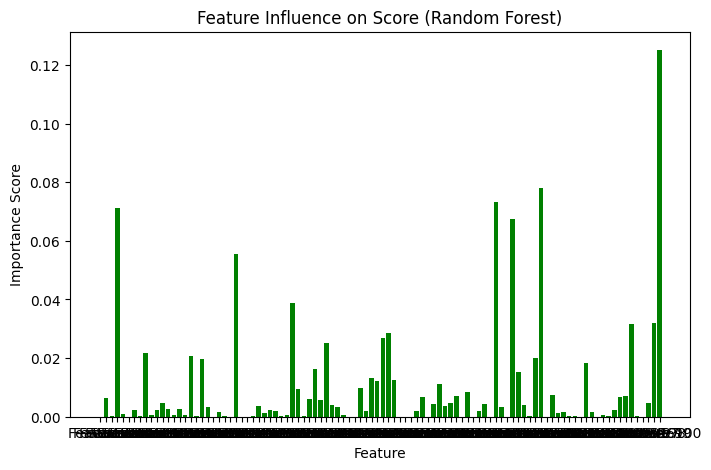

        Feature  Importance
99  Feature 100    0.125084
78   Feature 79    0.077901
70   Feature 71    0.073258
3     Feature 4    0.071192
73   Feature 74    0.067323
24   Feature 25    0.055477
34   Feature 35    0.038858
98   Feature 99    0.031996
94   Feature 95    0.031529
51   Feature 52    0.028717


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd

vlexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

X = np.array(list(lexicon_embedded.values()))
y = np.array([v[0] for v in lexicon.values()])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances
importance_rf = rf.feature_importances_

feature_names = [f"Feature {i+1}" for i in range(X.shape[1])]

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(feature_names, importance_rf, color="green")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Influence on Score (Random Forest)")
plt.show()

# Print feature importance
feature_importance_rf = pd.DataFrame({"Feature": feature_names, "Importance": importance_rf})
print(feature_importance_rf.sort_values(by="Importance", ascending=False)[:10])


In [18]:
# Get indexes of features with importance > 0.04
important_feature_indexes = np.where(importance_rf > 0.04)[0]

# Print result
print("Indexes of most important features:", important_feature_indexes)

Indexes of most important features: [ 3 24 70 73 78 99]


In [20]:
lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

x_train, y_train = [], []
for key in lexicon.keys():
    important_values = []
    for i in important_feature_indexes:
        important_values.append(adjectives_vectors[key][i])
    x_train.append(important_values)
    y_train.append([lexicon[key][0], 0])

x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

    # Train the model
model.fit(x_train, y_train)

for key in adjectives_vectors:
    important_values = []
    for i in important_feature_indexes:
        important_values.append(adjectives_vectors[key][i])
    result = model.predict([important_values])
    lexicon_trained[key][0] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)


abandoned : [0.5486681878355949, 0, 0, 0, 0, 0]
able : [0.2786191329553097, 0, 0, 0, 0, 0]
absolute : [0.4494940066117147, 0, 0, 0, 0, 0]
adorable : [0.3354374792276974, 0, 0, 0, 0, 0]
adventurous : [0.30175081906132595, 0, 0, 0, 0, 0]
academic : [0.10654594475349505, 0, 0, 0, 0, 0]
acceptable : [0.3548064934405259, 0, 0, 0, 0, 0]
acclaimed : [0.3922733839885639, 0, 0, 0, 0, 0]
accomplished : [0.1963125107184642, 0, 0, 0, 0, 0]
accurate : [0.547483080029996, 0, 0, 0, 0, 0]


## All together, from the very beginning, one by one: important steps:

In [21]:
# imports section
import numpy as np
import math
from numpy import dot
from numpy.linalg import norm
from gensim import corpora, models, similarities
import string

import gensim.downloader as api
from gensim.models import Word2Vec

import itertools

In [22]:
# vectorization example:
# Define the lexicon with mood vectors
moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}
moods_indeces = {y.lower(): x for x, y in moods.items()}

lexicon = {
    "anxious": [0.3, 0.9, 0.4, 0, 0, 0.1], "furious": [0.9, 0.3, 0.2, 0, 0, 0],
    "peaceful": [0, 0, 0, 1, 0.4, 0.2], "hate": [0.9, 0.3, 0.3, 0, 0, 0],
    "joyful": [0, 0, 0, 0.2, 0.9, 0.7], "unacceptable": [0.9, 0.6, 0.6, 0, 0, 0],
    "thrilled": [0, 0, 0, 0, 0.6, 1], "infuriating": [0.9, 0.8, 0.6, 0, 0, 0],
    "irate": [0.9, 0.2, 0.1, 0, 0, 0], "terrible": [0.9, 0.7, 0.7, 0, 0, 0],
    "nervous": [0.2, 0.8, 0.3, 0.1, 0, 0.2], "melancholy": [0.1, 0.4, 0.9, 0.2, 0, 0], 
    "depressed": [0.1, 0.1, 0.9, 0.2, 0, 0], "gloomy": [0.1, 0.1, 0.8, 0.3, 0, 0], 
    "serene": [0, 0, 0, 0.9, 0.8, 0.9], "elated": [0, 0, 0, 0.1, 0.8, 0.9],
    "ecstatic": [0, 0, 0, 0, 0.7, 1], "overjoyed": [0.1, 0.1, 0.1, 0.1, 1, 0.9], 
    "gleeful": [0.1, 0.1, 0.1, 0.1, 0.9, 0.8], "cheerful": [0.1, 0.1, 0.1, 0.1, 0.8, 0.5], 
    "optimistic": [0.1, 0.2, 0.1, 0.7, 0.8, 0.6], "buoyant": [0.1, 0.2, 0.1, 0.8, 0.7, 0.7], 
    "enthusiastic": [0.2, 0.3, 0.1, 0.6, 0.8, 0.9], "upbeat": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7], 
    "festive": [0.1, 0.1, 0.1, 0.7, 0.8, 0.7], "playful": [0.1, 0.2, 0.1, 0.6, 0.7, 0.8], 
    "vivacious": [0.1, 0.2, 0.1, 0.6, 0.8, 0.7], "jovial": [0.1, 0.2, 0.1, 0.7, 0.8, 0.7], 
    "amused": [0.1, 0.2, 0.1, 0.6, 0.7, 0.7], "blissful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7], 
    "grateful": [0.1, 0.1, 0.1, 0.8, 0.9, 0.7], "tranquil": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6], 
    "relaxed": [0.1, 0.1, 0.1, 0.9, 0.8, 0.6], "comfortable": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "cozy": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], "warm": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], 
    "inviting": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], "satisfied": [0.1, 0.1, 0.2, 0.6, 0.5, 0.3], 
    "pleasant": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], "pleased" : [0.1, 0.1, 0.1, 0.9, 0.8, 0.3], 
    "mellow": [0.1, 0.1, 0.1, 0.8, 0.8, 0.6], "happy": [0.1, 0.1, 0.1, 0.7, 1, 0.6]
    }

In [23]:
# prepare data
# load corpus
corpus = api.load('glove-wiki-gigaword-100')
vector = corpus['computer']
# print(vector)

# read adjactives file
data = ''
with open('../resources/sets/english-adjectives.txt', 'r') as file:
    data = file.read().replace('\n', ',')

adjectives = data.split(',')
# print(adjectives[:20])


adjectives_vectors = {}

for adjective in adjectives:
    adjectives_vectors[adjective] = corpus[adjective]

for key, value in itertools.islice(adjectives_vectors.items(), 2):
    print(key, ":", value)

abandoned : [ 0.43756    0.22949   -0.24099    0.42471   -0.25692    0.073755
 -0.096612   0.46294    0.85405    0.30859    0.35545    0.81983
  0.20312   -0.1225     0.17376   -0.62581    0.48522    0.23915
 -0.24558   -0.11948    0.69671    0.57527    0.65548   -0.029388
 -0.19702   -0.4308    -0.77335   -0.5166    -0.201      0.48815
  0.23728    0.31009   -0.25274   -0.042121  -0.19871   -0.17874
  0.019558  -0.42301    0.0743    -0.073421  -0.57583   -0.30048
  0.64496   -0.071048   0.52107    0.17243   -0.13616    0.97539
  0.23503   -0.28925   -0.072434   0.10553    0.24934    0.82306
  0.21013   -1.7977    -0.54545   -0.29966    1.0294     0.16126
  0.081623   0.53188    0.20484    0.36831    0.7118    -0.23808
  0.16678   -0.16994   -0.56703   -0.22874   -0.042396  -0.0065193
  0.01364   -0.2084    -0.35861   -0.055815   0.16845    0.46759
 -0.9905     0.35124   -0.070496   0.20322   -0.20443    0.75299
 -0.70367    0.19664    0.045248  -0.044681  -0.95952    0.31755
 -0.11741

In [24]:
# dimensionality reduction via random forest feature extraction, svm in cycle for every component

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lexicon_embedded = {}

for word in lexicon.keys():
    lexicon_embedded[word] = adjectives_vectors[word]

lexicon_trained = {}
for key in adjectives_vectors:
    lexicon_trained[key] = [0, 0, 0, 0, 0, 0]

for i in range(6):
    X = np.array(list(lexicon_embedded.values()))
    y = np.array([v[i] for v in lexicon.values()])

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)

    # Get feature importances
    importance_rf = rf.feature_importances_
    # Get indexes of features with importance > 0.04
    important_feature_indexes = np.where(importance_rf > 0.04)[0]

    # Print result
    print(f"Indexes of most important features for {i}:", important_feature_indexes)

    # Create a pipeline with StandardScaler and SVR, wrapped in MultiOutputRegressor
    model = MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0)))

    x_train, y_train = [], []
    for key in lexicon.keys():
        important_values = []
        for j in important_feature_indexes:
            important_values.append(adjectives_vectors[key][j])
        x_train.append(important_values)
        y_train.append([lexicon[key][i], 0])

    x_train_np = np.array(x_train)
    y_train_np = np.array(y_train)

    # Train the model
    model.fit(x_train, y_train)

    for key in adjectives_vectors:
        important_values = []
        for j in important_feature_indexes:
            important_values.append(adjectives_vectors[key][j])
        result = model.predict([important_values])
        lexicon_trained[key][i] = result[0][0]

for key, value in itertools.islice(lexicon_trained.items(), 10):
    print(key, ":", value)

# moods = {0: "Angry", 1: "Worried", 2: "Sad", 3: "Calm", 4: "Happy", 5: "Excited"}

Indexes of most important features for 0: [ 3 24 70 73 78 99]
Indexes of most important features for 1: [ 6 57 77]
Indexes of most important features for 2: [ 6 34 73 77 87]
Indexes of most important features for 3: [ 3  8 41 42]
Indexes of most important features for 4: [ 6  8 34 38 40 73 77]
Indexes of most important features for 5: [ 8 34 38 40 53]
abandoned : [0.5486681878355949, 0.47062416113222927, 0.38359808673471113, 0.4588480317556811, 0.12163844934457307, 0.09957475052909831]
able : [0.2786191329553097, 0.20262337156979324, 0.06466568285103341, 0.23724384453675024, 0.6747227093815318, 0.2966139232023028]
absolute : [0.4494940066117147, 0.33378779337734676, 0.31559845033282263, 0.6490652162333584, 0.5129485212228615, 0.5090630856701435]
adorable : [0.3354374792276974, 0.0666724772120803, 0.158594782851804, 0.10601693686709868, 0.65561091839924, 0.7573534050125633]
adventurous : [0.30175081906132595, 0.19666645918428138, 0.22543710150172871, 0.2644411066144988, 0.54807839476016

**TODO**:

1. cross-validation, fine tuning
2. Find political data, find more words!
3. fuzzy logic rule generation! (may be via evolut. algorithms)
4. apply fl rules
5. results!